# Advanced Lane Finding Project
---
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Compute Camera Calibration and Correct Lens Distortion

Camera calibration is the process of undoing the light distortion by the camera lens that warps certain parts of the image.  The magnitude of distortion depends on the physical shape of the lens.  The following steps are involved in camera calibration.

1. A number of images need to be taken of a chessboard pattern by the camera which we want to calibrate.
    * The chessboard is essentially a grid of known corners where the chess spaces intersect.  These generated corners are known objective points on a grid that can be algorithmically generated for correlation with the corresponding corners detected from the camera images (called image points) to measure the distortion produced by the camera lens.  
    * The chessboard pattern and the camera images are provided for this project.
2. Generate the objective points on the chess board.
3. Detect the chessboard corners (image points) on the camera images.
4. Feed objective points and image points into the OpenCV cv2.calibrateCamera method to compute the camera calibration matrix and distortion coefficients.
5. Call cv2.undistort method with the camera calibration matrix and the distortion coefficients to undo the distortion effect of the camera lens on a test camera image to verify correctness.
6. Save the camera calibration matrix and the distortion coefficients to a pickle file for later use in correcting other images taken from the same camera.

The code cell below performs steps 1 through 3, above.  It also saves the images of the detected corners in _output_images/corners_ for later review.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_file = fname.replace('camera_cal/', 'output_images/corners/corners_')
        mpimg.imsave(corner_file, img)

Now that we have the objective points and the image points, we are ready to compute the camera calibration matrix and distortion parameters.  The code cell below performs steps 3 to 6, above, as well as plotting the last test camera image and its undistorted image for visual comparison.  The undistorted images can also be seen in the output_images folder.  As shown below, the most visible sign of removing the camera lens distortion is the straigtening of the curve lines near the edges of the image.

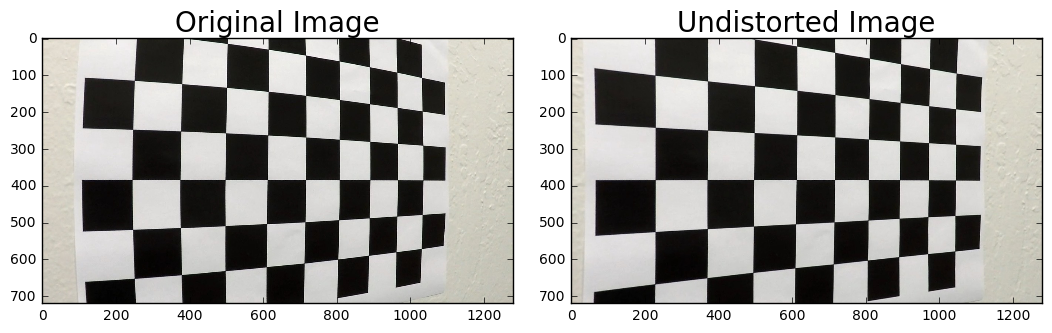

In [2]:
import pickle

# Do camera calibration given object points and image points
img_size = img.shape[0:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Undistort three test images and write them out to disk for review.
calibration_test_images = ['calibration2', 'calibration3', 'calibration5']
for test_name in calibration_test_images:
    img = mpimg.imread('camera_cal/' + test_name + '.jpg')
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/' + test_name + '_undistorted.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("camera_cal_pickle.p", "wb") )

# Plot the last distorted and undistorted test images for visual comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## Create a Thresholded Binary Image to Reveal Lane Lines from Forward Camera View

Reliably detecting lane lines and curvature to guide the steering of self-driving cars is a challenging proposition due to varying light conditions, road and lane line coloration, weather effects and shadows, and various other visual artifacts and interferences.  Fortunately, we do have a number of computer vision methods available to help, all thanks to OpenCV.

In this section the task is to transform an image of the road from a forward facing camera into a binary image where the lane lines are white and everything else around them are black, thus effectively detecting them.  We'll do this by taking the following steps:

1. Define the image processing methods which will be used in the process.
2. Create a pipeline through which we'll apply the above image processing methods in sequence.
3. Run the pipeline with a variety of parameters to see which parameter combination works best for detecting lane lines.

### Undistort the Camera Image

We'll start with a method to undistort the road image.

In [3]:
camera_calibration_pickle = pickle.load( open("camera_cal_pickle.p", "rb") )
calibration_matrix = camera_calibration_pickle["mtx"]
distortion_params = camera_calibration_pickle["dist"]

def undistort(image):
    return cv2.undistort(image, calibration_matrix, distortion_params, None, calibration_matrix)

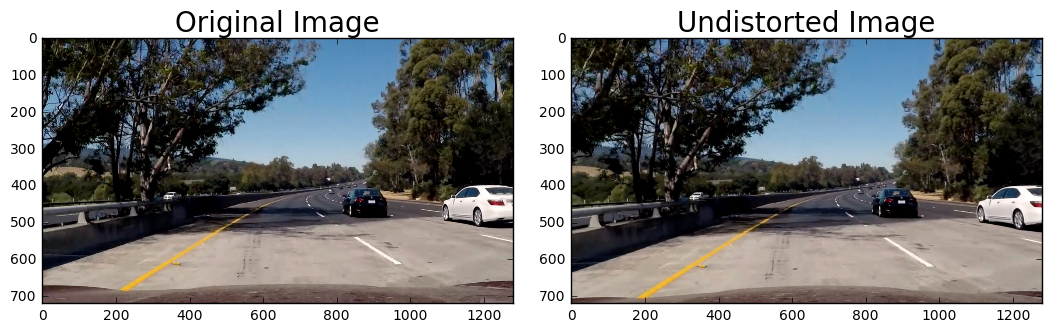

In [4]:
# Read in test image and undistort it.
test_name = 'test_images/test5.jpg'
img = mpimg.imread(test_name)
dst = undistort(img)

# Save output image to disk for review
output_name = test_name.replace('test_images/', 'output_images/undistorted_')
mpimg.imsave(output_name, dst)

# Visualize the before and after images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Looks like the lens distortion of this image is not too bad.  In the undistorted image, less of the car's hood is visible, and yellow and white lane lines are stretched slightly more toward the edge of the image.  This can most easily be seen by looking at where the yellow lane meets the hood: at slightly more than 200 pixels in the original image, but at slightly less than 200 pixels in the undistorted image.

### Using Color and Gradient to Produce Thresholded Binary Image

In this step we'll apply a number of techniques to try to isolate the pixels making up the lane lines from the remainder of the road image.  We'll do this by creating a pipeline where one or more image processing/computer vision methods will be applied to the image's pixel values.  I expect a lot of trial and errors, and I want to specify the various methods and parameter values succinctly, so the pipeline that I created will be defined by a dictionary of methods and parameters.  That way, to try something different I just change content of the dictionary and pass it through the pipeline, for I can even generate the dictionary procedurally to try out a range of settings and/or a variety of method combinations.  The pipeline code saves images for both the 

The pipeline code is in the file **pipeline.py** in the same folder as this notebook. I've run over a dozen method combinations, often with multiple parameter values each, resulting in hundreds of processed road images for the following four test images that I considered most challening due to shadows and varying light conditions on the road.  I started with some of the suggested starting points during the lectures.  Then when I found some effective outputs, I run experiments on the individual methods of those approaches to see what they look like.  After I've seen those outputs, I proceeded to try out some new combinations guided by what I've learned.  The code cell below contains the four _hard_ images that I used for testing as well the list of pipeline parameter dictionaries that were part of my experiments, in the order that I ran them.

In [5]:
hard_test_images = ['test1.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

test_parameters = [\
    {'color_s': (170, 255), 'sobel_abs_x_l': (50, 150, 5), 'stack': ['color_s', 'sobel_abs_x_l']},\
    {'color_s': (170, 255), 'sobel_mag_b_l': (40, 100, 9), 'stack': ['color_s', 'sobel_mag_b_l']},\
    {'color_s': (170, 255), 'sobel_mag_x_l': (40, 100, 9), 'stack': ['color_s', 'sobel_mag_x_l']},\
    {'color_s': (170, 255), 'sobel_dir_l': (0.7, 1.2, 15), 'stack': ['color_s', 'sobel_dir_l']},\
    {'sobel_abs_x_l': (20, 100, 3), 'sobel_abs_y_l': (20, 100, 3), 'sobel_mag_x_l': (40, 100, 9),\
        'sobel_dir_l': (0.7, 1.2, 15), 'combine': [['sobel_abs_x_l', 'sobel_abs_y_l'],\
        ['sobel_mag_x_l', 'sobel_dir_l']]},
    {'sobel_abs_x_l': (20, 100, 3), 'sobel_abs_y_l': (20, 100, 3), 'sobel_mag_x_l': (40, 100, 9),\
        'color_s': (170, 255), 'combine': [['sobel_abs_x_l', 'sobel_abs_y_l'],\
        ['color_s', 'color_s']]},
    {'color_s': (150,255), 'single': 'color_s'}, 
    {'color_l': (100,200), 'single': 'color_l'},
    {'color_h': (15,100), 'single': 'color_h'},
    {'sobel_mag_x_l': (30,200, 5), 'single': 'sobel_mag_x_l'},
    {'sobel_abs_x_l': (25,100, 5), 'single': 'sobel_abs_x_l'},
    {'sobel_mag_y_l': (30,100, 3), 'single': 'sobel_mag_y_l'},
    {'sobel_abs_y_l': (20,100, 3), 'single': 'sobel_abs_y_l'},
    {'sobel_mag_b_l': (50,100, 9), 'single': 'sobel_mag_b_l'},
    {'sobel_dir_l': (0.7, 1.2, 15), 'single': 'sobel_dir_l'},
    {'color_s': (150, 255), 'sobel_abs_x_l': (25, 100, 5),\
        'combine': [['color_s', 'color_s'],['sobel_abs_x_l', 'sobel_abs_x_l']]},
    ]

The key in each entry in the parameter dictionaries above define a color or gradient operation.  The value in each entry is a tuple containing the threshold parameters (first two elements), and for the sobel operations also the kernel size (third element).

Then there are the three operations for outputing the final thresholded binary image with the keys 'single', 'stack', and 'combine'. The key 'single' means apply the single thresholding operation specified in the value of the entry to produce the thresholded binary image.  The key 'stack' means that the value will be a list of thresholding operations that should be stacked in different color channels to produce the final thresholded binary image.  The key 'combine' means that the value will be a list of four operations that are combined as follows:

    ouptut_pixel = (operation1 == 1 & operation2 == 1) | (operation3 == 1 & operation4 == 1) == 1

Up to four operation can be thus combined, though 2 or 3 operations can also be specified by simply duplicating one or two operations.  While not very flexible and could result in some unnecessary work, it's simple and effective.

Stack and combine are thus two ways in much multiple color and/or gradient operations can be used together to better detect lane line pixels.  This is important because no one method will be sufficiently robust over all road, lighting, and weather conditions.  The key to effective lane finding is to use multiple complementary methods together.

The above list captures only a subset of the experiments that I ran, since I often modified the thresholding parameter values without creating a new entry in the above list of dictionaries.  However, the pipe_line code save images with the parameter values encoded in the image file names.  These images are saved to the **param[X]** subfolders of the **output_images** folder, where [X] is the list index of the _test_parameters_ list in the above code cell, and so nearly all the results of all my experiments should have been preserved in those **output_images/param[X]** folders.  There are hundreds of images in these folders from the experiments I ran, and I've included them all in the GitHub repository for review.

From these experiments I found that the saturation value of the HLS color space is quite effective and is well complemented by the Sobel magnitude calculation with the x orientation.  In the code cells below I will run a few of the more promising entries to show how I selected the methods for binary thresholding.

In [6]:
from pipeline import pipeline
from math import ceil

# Load hard test images into a dictionary with file name keys, undistorting them before storing them.
# hard_images will contain undistorted images.
hard_images = []
for file_name in hard_test_images:
    hard_images.append((file_name, undistort(mpimg.imread('test_images/' + file_name))))

# A method to plot the thresholded test images after a pipeline run.
def plot_images(named_image_list, images_per_row, figure_size=(10,4)):
    """
    named_image_list: A list of tuples in the form (image_name, image)
    """
    rows = ceil(len(named_image_list) / images_per_row)
    f, axes = plt.subplots(rows, images_per_row, figsize=(figure_size[0], figure_size[1] * rows))
    f.tight_layout()
    index = 0
    for key, value in named_image_list:
        axes[index].imshow(value, cmap="gray")
        axes[index].set_title(key, fontsize=20)
        index += 1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Run the pipeline on the nth parameter dictionary (0-based) in the test_parameters list.
def run_pipeline_with_test_parameter_index(index, named_image_list):
    binary_list = []
    for key, value in named_image_list:
        binary_list.append((key, pipeline(value, 'param{}'.format(index), test_parameters[index], key)))
    plot_images(binary_list, 4)

For starters, let just show the test images that will be used to judge the effectiveness of different methods and parameters.

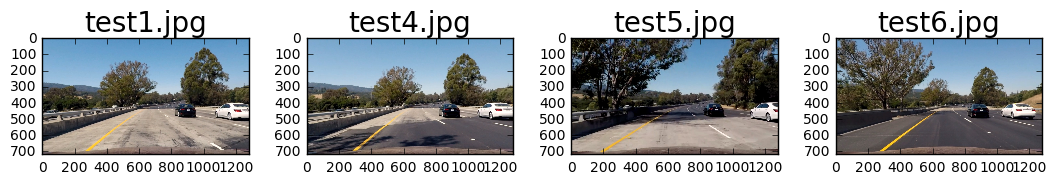

In [7]:
plot_images(hard_images, 4)

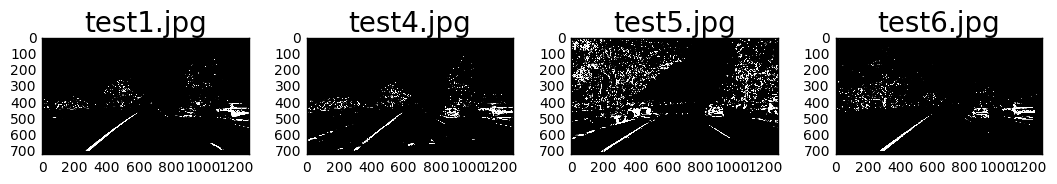

In [8]:
# Run the pipeline on index 6 to show the effect of just thresholding the saturation color channel
run_pipeline_with_test_parameter_index(6, hard_images)

As shown above, just using thresholding the HLS saturation channel did a great job of identifying the solid left yellow lane, but not a very good job on the intermittent while lane lines that are far away, near the horizon.  Below I tried just using the sobel absolute thresholding with x orientation (index = 10).

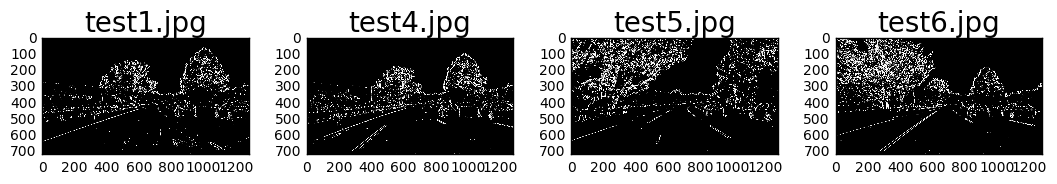

In [9]:
# Run the pipeline on index 10 to show the effect of absolute gradient thresholding with x orientation.
run_pipeline_with_test_parameter_index(10, hard_images)

The above didn't do a good job on the left yellow lane but in test5.jpg and test6.jpg that had shadows further out, it did detect the farther white lane lines better that the saturation thresholding.  At least on these test images these two methods seems to be good complements, so below they are _OR_ combined (method index 15)

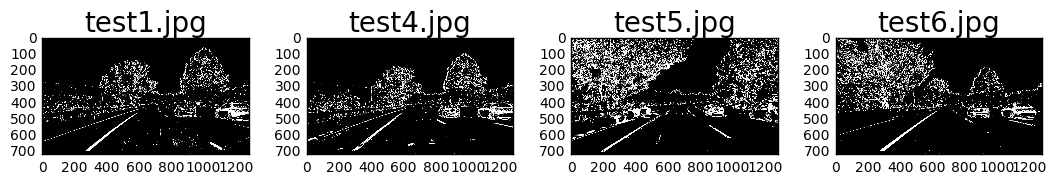

In [10]:
# Run the pipeline on index 15 to combine color_s and sobel_abs_x_l
run_pipeline_with_test_parameter_index(15, hard_images)

In [11]:
# Now test with the remaining images to see if they look OK.
easy_test_images = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test2.jpg', 'test3.jpg']

# easy_images will contain undistorted images.
easy_images = []
for file_name in easy_test_images:
    easy_images.append((file_name, undistort(mpimg.imread('test_images/' + file_name))))

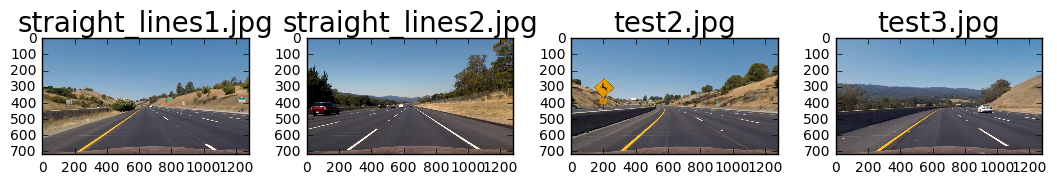

In [12]:
plot_images(easy_images, 4)

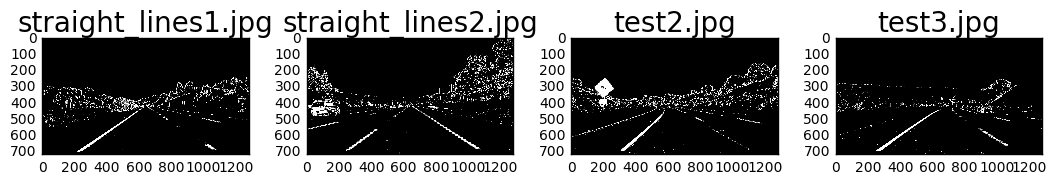

In [13]:
# Run the pipeline on index 15 to combine color_s and sobel_abs_x_l
run_pipeline_with_test_parameter_index(15, easy_images)

As expected what works well for the hard test images will also work good with the easy test images.

### Limitations and Improvements

The above is one static combination that works well in the tested lighting condition and lane colors.  This one static combination of color and gradient filtering would likely  work for all lighting conditions, like at night with head lights or when the road is wet with rain.  One improvement could be to adaptively select from among several methods and/or use varying parameters to find the best detection method for any given road condition.  To this there an objective function of what good lane line detection would look like and then see which among several filtering combinations work well.  Another dynamic approach is to somehow find good complementary approaches dynamically, instead of just matching two complementary approaches like was done above.

## Perspective Transform

The next task is to project the detected lane lines to a top down view in order to quantify curvature in the road.  We'll do this by mapping some pixel coordinates from an undistorted road image where the lanes are straight (as far as we can tell) to the corresponding pixel coordinates in a top down view of the road.  In the code below, we'll undistort the straight_lines1.jpg test image for this purpose.

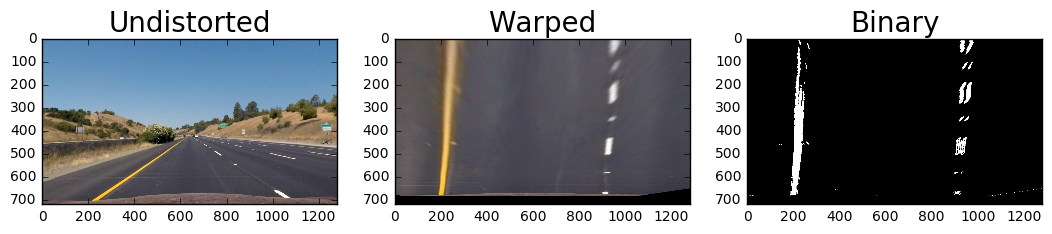

In [14]:
# Coordinates from forward view and topdown view for making perspective transform
forward_coords = np.float32([[590, 450], [700, 450], [1206, 670], [278, 670]])
topdown_coords = np.float32([[200, 0], [1080, 0], [1080, 670], [200, 670]])

# Get perspective tranform
M = cv2.getPerspectiveTransform(forward_coords, topdown_coords)

def make_topdown_binary(undistorted_image, index):
    # Make cv2 format image size.
    image_size = undistorted_image.shape[0:2]
    cv2_image_size = (image_size[1], image_size[0]) # cv2 size is (width, height)

    # Warp the undistorted image with the perspective transform 
    warped = cv2.warpPerspective(undistorted_image, M, cv2_image_size, flags=cv2.INTER_LINEAR)

    # Now apply the pipeline to get the binary topdown lane image
    binary = pipeline(warped, 'topdown', lane_parameters[index], None)    
    
    return binary, warped

def visualize_topdown(undistorted_image, index):
    binary, warped = make_topdown_binary(undistorted_image, index)
    
    # Visualize
    perspective_visualize = [('Undistorted', undistorted_image), ('Warped', warped), ('Binary', binary)]
    plot_images(perspective_visualize, 3)


# Let's copy down the parameters used to find lane lines in the forward image and adjust it to 
# work with the top-down image
# lane_parameters = {'color_s': (150, 255), 'sobel_abs_x_l': (25, 100, 5),\
#        'combine': [['color_s', 'color_s'],['sobel_abs_x_l', 'sobel_abs_x_l']]}
lane_parameters = [ \
    {'color_s': (140, 255), 'sobel_abs_x_l': (25, 100, 9), 'sobel_abs_y_l': (25, 100, 5), \
       'combine': [['color_s', 'color_s'],['sobel_abs_x_l', 'sobel_abs_x_l']]},
    {'color_s': (180, 255), 'single': 'color_s' }, \
    {'color_h': (0, 100), 'single': 'color_h' }, \
    {'color_l': (50, 150), 'single': 'color_l' }, \
    {'sobel_abs_x_l': (25, 100, 9), 'single': 'sobel_abs_x_l' }, \
    {'sobel_abs_y_l': (25, 100, 9), 'single': 'sobel_abs_y_l' }, \
    {'sobel_mag_b_l': (50,100, 9), 'single': 'sobel_mag_b_l'}, \
    {'sobel_dir_l': (0.7, 1.2, 15), 'single': 'sobel_dir_l'}, \
    {'color_s': (140, 255), 'sobel_abs_x_l': (25, 100, 9), 'sobel_dir_l': (0.8, 1.2, 15), \
       'combine': [['color_s', 'color_s'],['sobel_abs_x_l', 'sobel_dir_l']]} \
    ]

# Undistort straight line image
straight_name = 'test_images/straight_lines1.jpg'
straight = mpimg.imread(straight_name)
undist = undistort(straight)

# Save output image to disk for review
output_name = straight_name.replace('test_images/straight', 'output_images/undistorted_straight')
mpimg.imsave(output_name, undist)

visualize_topdown(undist, 0)

**Note:** 

The lane_parameters list in the above code cell looks different than the test_parameters list used for identifying lanes in the forward-looking images.  This is because performing binary thresholding on top-down view images are an entirely different challenge than forward looking images.  The final set of lane parameters (index = 8) also adds a sobel direction gradient which helped to eliminate the shoulder lines from showing up prominently in the binary image. The code cell below produces the top-down binary images without the direction gradient.  Notice the prominence of the shoulder line on the top left corners of the test1.jpg, test4.jpg, and test6.jpg images.

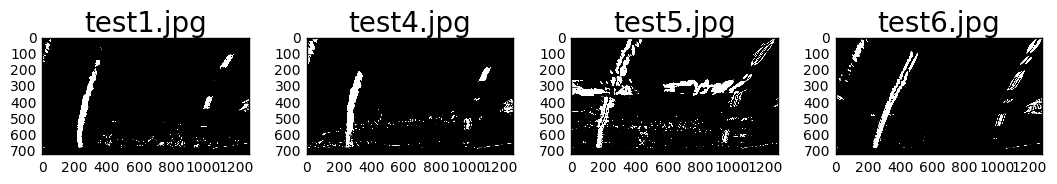

In [15]:
# No direction gradient (lane_parameters index = 0)
binary_images = []
for file_name, image in hard_images:
    binary, _ = make_topdown_binary(image, 0)
    binary_images.append((file_name, binary))
plot_images(binary_images, 4)

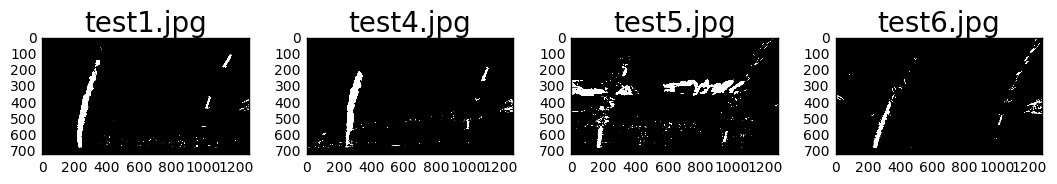

In [16]:
# with direction gradient (lane_parameters index = 8), the shoulder lines are removed.
binary_images = []
for file_name, image in hard_images:
    binary, _ = make_topdown_binary(image, 8)
    binary_images.append((file_name, binary))
plot_images(binary_images, 4)

Note that while the shoulder lines were removed above, we still have some white pixels from the car in the next lane as well as the stretch of shadows across the test5.jpg image.  These artifacts will interfere with trying to find the lane line pixels using the histogram method in the next step.  One way to reduce/remove the shadow effect in test5.jpg is to increase the lower threshold of the saturation channel thresholding (color_s), say to 170 or more (try index = 1).  However, this also drastically reduce the lane line detected by the saturation thresholding.  I have not found a way to remove these artifacts without also massively reducing lane line detection in other instances and so had to settle on a compromise lower saturation thresholding value.

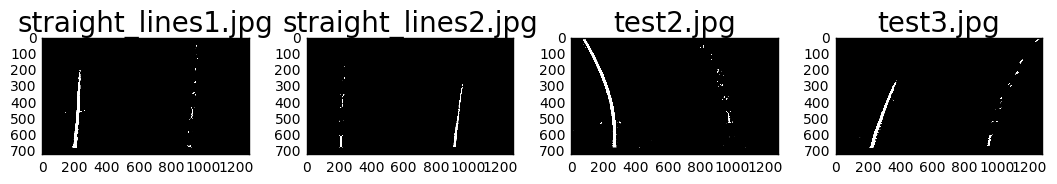

In [17]:
# now show easy test images with lane_parameters index = 8 (with direction gradient)
# easy test images
binary_images = []
for file_name, image in easy_images:
    binary, _ = make_topdown_binary(image, 8)
    binary_images.append((file_name, binary))
plot_images(binary_images, 4)

Now we have the perspective transformation matrix **M** to use for transforming forward-looking camera images to topdown views in order to find the lane line pixels on the road for measuring lane curvatures.  

### Limitations and Improvements

Flat road approximation for transform points selection is one limitation of this implementation.  If the road is sloping up or down, the perspective transform will be incorrect and also the resulting radius of curvature calculations.

--
## Lane Curvature Determination

With the above binary images we now have the raw data for lane curvature determination.  The next step is to determine where the lane pixels are in the image.  We do this by looking at the histogram of pixel values near the bottom of the screen and then slide up the screen to follow the lane pixels.

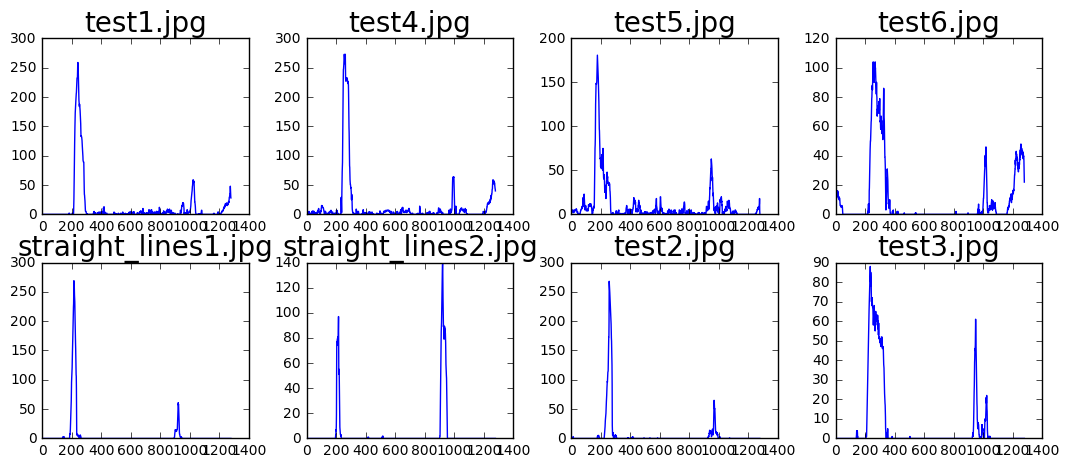

In [18]:
from math import floor

def create_lane_histogram_data(image, top, bottom, left, right):
    """
    Create the lane histogram data from some portion of the image.
    :param image: The binary image containing the topdown lane pixels
    :param image_fraction: How much of the image to use, from the bottom up.
    """
    return np.sum(image[top:bottom,left:right], axis=0)

def plot_lane_histograms(histogram_data_list, images_per_row, figure_size=(10,2)):
    """
    Plot the lane histogram data
    :param named_image_list: A list of tuples in the form (image_name, histogram_data)
    """
    rows = ceil(len(histogram_data_list) / images_per_row)
    f, axes = plt.subplots(rows, images_per_row, figsize=(figure_size[0], figure_size[1] * rows))
    f.tight_layout()
    index = 0
    for key, value in histogram_data_list:
        if rows == 1:
            axes[index].plot(value)        
            axes[index].set_title(key, fontsize=20)
        else:
            row = floor(index / images_per_row)
            col = index % images_per_row
            axes[row, col].plot(value)
            axes[row, col].set_title(key, fontsize=20)
        index += 1
    plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

image_size = hard_images[0][1].shape
top = floor(image_size[0] * 0.5)
bottom = image_size[0]
left = 0
right = image_size[1]
histogram_data = []
binaries = dict()
for name, value in hard_images:
    binary, _ = make_topdown_binary(value, 8)
    histogram_data.append((name, create_lane_histogram_data(binary, top, bottom, left, right)))
    binaries[name] = binary

for name, value in easy_images:
    binary, _ = make_topdown_binary(value, 8)
    histogram_data.append((name, create_lane_histogram_data(binary, top, bottom, left, right)))
    binaries[name] = binary
    
plot_lane_histograms(histogram_data, 4)


As can be seen above, the lower row of easy images produced much cleaner histograms showing the lane locations than the harder images in the top row.  Now we need to extract the lane pixels using the sliding window approach and then convert them from pixel coordinates to world coordinates, which is done in the code cell below.

In [41]:
# start with the assumption that lane lines will be found on the two halves of the binary image.
image_width = image_size[1]
side_margin = 100  # Hack here to disregard noise from other cars at edge of the image at cost of reduced FOV.
border = floor(image_width / 2)  # start with a border at the middle of the image... will adjust when lane lines found.
left_lane = histogram_data[3][1][side_margin:border].argmax() + side_margin  # pixel column of left lane line.
right_lane = histogram_data[3][1][border:image_width - side_margin].argmax() + border # right lane line pixel column.
# print(left_lane, right_lane)

# Will call our sliding window 'box' for short in variable names.
box_half_width = 100
box_height = 60

def get_lane_pixels(binary_topdown_image):
    leftx = []
    lefty = []
    rightx = []
    righty = []
    box_top = image_size[0] - box_height
    
    histogram_values = create_lane_histogram_data(binary_topdown_image, 0, image_size[0], 0, image_size[1])
    
    # start with the assumption that lane lines will be found on the two halves of the binary image.
    left_lane = histogram_values[side_margin:border].argmax() + side_margin  # pixel column of left lane line.
    right_lane = histogram_values[border:image_width - side_margin].argmax() + border # right lane line pixel column.
    
    while box_top >= 0:
        # Find lane line maximum value when box is slide up.  Will use for new lane line centers each iteration.
        histogram_values = create_lane_histogram_data(binary_topdown_image, box_top - box_height, box_top, 0, \
            image_size[1])
        
        # print("left lane:", left_lane)
        # print("right lane:", right_lane)
        
        # Left lane
        box_left = max(0, left_lane - box_half_width)
        box_right = min(image_width, left_lane + box_half_width - 1)
        box_bottom = box_top + box_height
        for row in range(box_top,box_bottom):            
            for col in range(box_left,box_right):
                if binary_topdown_image[row, col] > 0:
                    leftx.append(col)
                    lefty.append(row)
        # Slide left box to center of bright pixels
        left_lane = histogram_values[box_left:box_right].argmax() + box_left
        
        # Right lane
        box_left = max(0, right_lane - box_half_width)
        box_right = min(image_width, right_lane + box_half_width - 1)
        box_bottom = box_top + box_height
        for row in range(box_top,box_bottom):
            for col in range(box_left,box_right):
                if binary_topdown_image[row, col] > 0:
                    rightx.append(col)
                    righty.append(row)
        
        # Slide right box to center of bright pixels
        right_lane = histogram_values[box_left:box_right].argmax() + box_left

        
        # Slide box up
        box_top -= box_height

        # print(box_top)
    return np.array(leftx), np.array(lefty), np.array(rightx), np.array(righty)

left_x, left_y, right_x, right_y = get_lane_pixels(binaries['test6.jpg'])
#print(len(left_pixels), len(right_pixels))

# Convert to real world coordinates
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_y = left_y * ym_per_pix
left_x = left_x * xm_per_pix
right_y = right_y * ym_per_pix
right_x = right_x * xm_per_pix

Now we're ready to apply a polynomial fit to the lane line pixel data and use the resulting fit to calculate the radius of curvature.

391.902455377 m 520.942073714 m


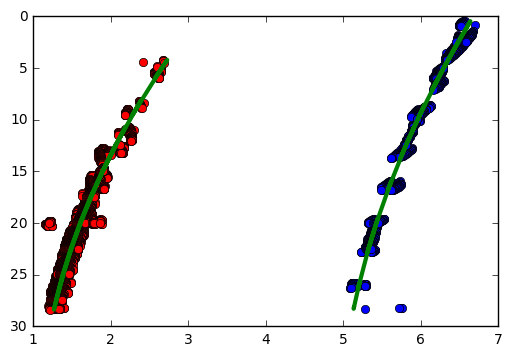

In [44]:
# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(left_y, left_x, 2)
left_fit_x = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
right_fit = np.polyfit(right_y, right_x, 2)
right_fit_x = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

# Calculate curve radius
left_maxy = np.max(left_y)
right_maxy = np.max(right_y)
left_curverad = ((1 + (2*left_fit[0]*left_maxy + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*right_maxy + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# Plot up the fake data
plt.plot(left_x, left_y, 'o', color='red')
plt.plot(right_x, right_y, 'o', color='blue')
plt.plot(left_fit_x, left_y, color='green', linewidth=3)
plt.plot(right_fit_x, right_y, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images